In [1]:
import json
import pickle
import time
from datetime import datetime, timedelta
from itertools import product

import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import joblib
import os

import matplotlib.pyplot as plt
from tqdm import tqdm

# Local modules
import modularised_utils as mut
import opt_utils as oput
import evaluation_utils as evut
import Linear_Additive_Noise_Models as lanm
import operations as ops
import params
import random

np.random.seed(0)

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.


In [2]:
experiment = 'battery_discrete'

In [3]:
T_results_emp = joblib.load(f"data/{experiment}/diroca_train_results_empirical.pkl")

In [4]:
#abduction       = False
coeff_estimation = False

# Define the number of samples per environment. Currently every environment has the same number of samples
if experiment == 'synth1' or experiment == 'synth1.1' or experiment == 'synth1.2':
    num_llsamples, num_hlsamples  = params.n_samples['synth1']
if experiment == 'lucas6x3' or experiment == 'lucas6x3.1' or experiment == 'lucas6x3.2' or experiment == 'lucas6x3.3':
    num_llsamples, num_hlsamples  = params.n_samples['lucas6x3']

Dll_obs, Dhl_obs  = mut.load_samples(experiment)[None][0], mut.load_samples(experiment)[None][1] 

Gll, Ill = mut.load_model(experiment, 'LL')
Ghl, Ihl = mut.load_model(experiment, 'HL')

n_varsll, n_varshl = len(Gll.nodes()), len(Ghl.nodes())

omega    = mut.load_omega_map(experiment)

if coeff_estimation == True:
    ll_coeffs = mut.get_coefficients(Dll_obs, Gll)
    hl_coeffs = mut.get_coefficients(Dhl_obs, Ghl) 
else:
    ll_coeffs = mut.load_coeffs(experiment, 'LL')
    hl_coeffs = mut.load_coeffs(experiment, 'HL')

U_ll_hat, mu_U_ll_hat, Sigma_U_ll_hat = mut.lan_abduction(Dll_obs, Gll, ll_coeffs)
U_hl_hat, mu_U_hl_hat, Sigma_U_hl_hat = mut.lan_abduction(Dhl_obs, Ghl, hl_coeffs)
# if abduction == True:
#     U_ll_hat, mu_U_ll_hat, Sigma_U_ll_hat = mut.lan_abduction(Dll_obs, Gll, ll_coeffs)
#     U_hl_hat, mu_U_hl_hat, Sigma_U_hl_hat = mut.lan_abduction(Dhl_obs, Ghl, hl_coeffs)
# else:
#     U_ll_hat, mu_U_ll_hat, Sigma_U_ll_hat = mut.load_exogenous(experiment, 'LL')
#     U_hl_hat, mu_U_hl_hat, Sigma_U_hl_hat = mut.load_exogenous(experiment, 'HL')

LLmodels = {}
for iota in Ill:
    LLmodels[iota] = lanm.LinearAddSCM(Gll, ll_coeffs, iota)
    
HLmodels = {}
for eta in Ihl:
    HLmodels[eta] = lanm.LinearAddSCM(Ghl, hl_coeffs, eta)

FileNotFoundError: [Errno 2] No such file or directory: 'data/battery_discrete/Ds.pkl'

In [43]:
# Load data
#data = mut.load_samples(experiment)

# Generate data
data = evut.generate_empirical_data(LLmodels, HLmodels, omega, U_ll_hat, U_hl_hat)

### Abstraction error comparison

In [44]:
test_observ        = True
test_interv        = True 


metric             = 'fro'
num_iter           = 20

In [45]:
if test_observ and test_interv:
    test_data = data

elif test_observ:
    test_data = {None: data[None]}

elif test_interv:
    test_data = {k: v for k, v in data.items() if k is not None}

In [46]:
#rad_values   = [1, 2]
rad_values = np.arange(0.05, 10.05, 1).tolist()  
#rad_values = [0.05, 1, 2,3, 4, 5, 10, 50]
sample_forms = ['boundary', 'sample']
center = 'hat'

In [47]:
hat_dict = {'L': U_ll_hat, 'H': U_hl_hat}

In [48]:
worst = 'T_2'

In [49]:
U_worst_L = T_results_emp[worst]['optimization_params']['L']['pert_U']
U_worst_H = T_results_emp[worst]['optimization_params']['H']['pert_U']


In [50]:
worst_dict = {'L': U_worst_L, 'H': U_worst_H}

In [51]:
dirocas = ['T_8', 'T_0.031', 'T_1', 'T_2', 'T_4']

In [52]:
def generate_perturbation_matrix(radius, sample_form, level, hat_dict, seed=None):
    """
    Generate a perturbation matrix either on the boundary or sampled from within a Frobenius ball.
    
    Args:
        radius: Radius of the Frobenius ball
        sample_form: Either 'sample' (from within ball) or 'boundary' (on boundary)
        level: The level key to access in the dictionaries
        hat_dict: Dictionary containing matrices for 'hat' case
        worst_dict: Dictionary containing matrices for 'worst' case
        seed: Optional random seed for reproducibility
    
    Returns:
        Perturbation matrix that can be added to a center matrix
    """
    if seed is not None:
        np.random.seed(seed)
    
    num_samples, num_vars = hat_dict[level].shape

    # Generate random perturbation matrix
    perturbation = np.random.randn(num_samples, num_vars)
    
    # Calculate norms
    squared_norm = np.linalg.norm(perturbation, 'fro')**2
    max_squared_norm = num_samples * radius**2
    
    # Calculate scaling factor based on sample type
    if sample_form == 'boundary':
        # Scale exactly to the radius
        scaling_factor = np.sqrt(max_squared_norm / squared_norm)
    elif sample_form == 'sample':
        # Scale to be within the radius
        scaling_factor = np.sqrt(max_squared_norm / squared_norm) * np.random.rand(1)
    
    return perturbation * scaling_factor

In [53]:
rad_values = np.arange(0.05, 10.05, 1).tolist()  
#rad_values = [0.05, 1, 2,3, 4, 5, 10, 50]
sample_forms = ['boundary', 'sample']

In [54]:
# Initialize results structure
results = {rad: {
    sample_form: {
        'empirical': {method: [] for method in T_results_emp.keys()}
    } for sample_form in sample_forms
} for rad in rad_values}

for rad in tqdm(rad_values):
    for sample_form in sample_forms:
        for iter_num in range(5):

            pert_L = generate_perturbation_matrix(rad, sample_form, 'L', hat_dict)
            pert_H = generate_perturbation_matrix(rad, sample_form, 'H', hat_dict)
            
            for name, method_data in T_results_emp.items():
                T = method_data['T_matrix']
                    
                total = 0
                for iota in test_data.keys():
                    base, abst = test_data[iota]
                    
                    # Apply perturbations
                    base_pert = base + pert_L
                    abst_pert = abst + pert_H
                    
                    # Normalize
                    base_norm = base_pert / np.linalg.norm(base_pert, 'fro')
                    abst_norm = abst_pert / np.linalg.norm(abst_pert, 'fro')
                    
                    # Apply method and compute distance
                    tau_base = base_norm @ T.T
                    dist = evut.compute_empirical_distance(tau_base, abst_norm, 'fro')
                    total += dist
                
                # Store average error for this iteration
                iter_avg = total / len(Ill)
                results[rad][sample_form]['empirical'][name].append(iter_avg)

# Print results
print("\n" + "="*100)
print(f"{'Radius':<8} {'Sample Form':<12} {'Method':<15} {'Error (mean ± CI)':<35}")
print("="*100)

for rad in rad_values:
    for sample_form in sample_forms:
        print(f"\nRadius: {rad}, Sample form: {sample_form}")
        print("-"*100)
        
        for method in T_results_emp.keys():
            # Compute statistics
            errors = results[rad][sample_form]['empirical'][method]
            error_mean = np.mean(errors)
            error_std = np.std(errors)
            ci = 1.96 * error_std  # 95% confidence interval
            
            # Print row
            print(f"{rad:<8} {sample_form:<12} {method:<15} "
                    f"{error_mean:>8.4f} ± {ci:<8.4f}")

# Find best methods
for rad in rad_values:
    for sample_form in sample_forms:
        print(f"\nBest method for radius {rad}, {sample_form} sampling:")
        
        error_means = {method: np.mean(results[rad][sample_form]['empirical'][method])
                        for method in T_results_emp.keys()}
        best_method = min(error_means.items(), key=lambda x: x[1])
        
        print(f"Best method: {best_method[0]} (error: {best_method[1]:.4f})")
    

100%|██████████| 10/10 [00:36<00:00,  3.63s/it]


Radius   Sample Form  Method          Error (mean ± CI)                  

Radius: 0.05, Sample form: boundary
----------------------------------------------------------------------------------------------------
0.05     boundary     T_8               1.4898 ± 0.0000  
0.05     boundary     T_0.215-0.046     1.4773 ± 0.0000  
0.05     boundary     T_1               1.4801 ± 0.0000  
0.05     boundary     T_2               1.4837 ± 0.0000  
0.05     boundary     T_4               1.4897 ± 0.0000  
0.05     boundary     T_0.00            0.8553 ± 0.0000  
0.05     boundary     T_b               1.4004 ± 0.0000  
0.05     boundary     T_s               0.7822 ± 0.0000  

Radius: 0.05, Sample form: sample
----------------------------------------------------------------------------------------------------
0.05     sample       T_8               1.4898 ± 0.0000  
0.05     sample       T_0.215-0.046     1.4773 ± 0.0000  
0.05     sample       T_1               1.4801 ± 0.0000  
0.05     samp

In [55]:
def plot_empirical_abstraction_error(results, methods, sample_form, figsize=(12, 8)):
    """
    Plot empirical abstraction error vs radius for specified methods and sample form.
    
    Parameters:
    -----------
    results : dict
        The results dictionary containing the empirical data
    methods : list
        List of method names to plot
    sample_form : str
        Either 'boundary' or 'sample'
    figsize : tuple
        Figure size (width, height)
    """
    plt.figure(figsize=figsize)
    
    # Define method styles for basic methods
    method_styles = {
        'T_0.00': {'color': 'purple', 'label': r'$\mathrm{T}_{0,0}$', 'marker': 'o'},
        'T_b': {'color': 'red', 'label': r'$\mathrm{T}_{b}$', 'marker': 's'},
        'T_s': {'color': 'green', 'label': r'$\mathrm{T}_{s}$', 'marker': '^'},
        'T_ba': {'color': 'orange', 'label': r'$\mathrm{T}_{ba}$', 'marker': 'D'}
    }
    
    # Generate color map for epsilon-delta methods
    n_colors = len([m for m in methods if '-' in m])  # Count methods with epsilon-delta format
    if n_colors > 0:
        colors = plt.cm.viridis(np.linspace(0, 1, n_colors))
        color_idx = 0
        
        # Add styles for epsilon-delta methods
        for method in methods:
            if '-' in method:
                eps, delta = method.replace('T_', '').split('-')
                method_styles[method] = {
                    'color': colors[color_idx],
                    'label': f'$\\mathrm{{T}}_{{\\varepsilon_l={eps},\\varepsilon_h={delta}}}$',
                    'marker': 'h'
                }
                color_idx += 1
    
    # Add styles for single parameter methods using blues
    blues = plt.cm.Blues(np.linspace(0.6, 1, 5))
    markers = ['h', 'v', 'p', '*', 'x']
    for i, eps in enumerate(['0.031', '1', '2', '4', '8']):
        method_name = f'T_{eps}'
        if method_name in methods:  # Only add if method is actually used
            method_styles[method_name] = {
                'color': blues[i],
                'label': f'$\\mathrm{{T}}_{{\\varepsilon={eps}}}$',
                'marker': markers[i]
            }
    
    # Extract radius values and sort them
    radius_values = sorted([float(r) for r in results.keys()])
    
    # Plot each method
    for method in methods:
        if method not in method_styles:
            print(f"Warning: No style defined for method {method}")
            continue
            
        style = method_styles[method]
        errors = []
        error_stds = []
        
        # Collect data for each radius
        for rad in radius_values:
            values = results[rad][sample_form]['empirical'][method]
            mean = np.mean(values)
            std = np.std(values)
            errors.append(mean)
            error_stds.append(1.96 * std)  # 95% confidence interval
        
        # Plot with error bands
        plt.plot(radius_values, errors,
                f"{style['marker']}-",
                color=style['color'],
                label=style['label'],
                alpha=0.8,
                markersize=12,
                linewidth=2)
        
        # plt.fill_between(radius_values,
        #                 np.array(errors) - np.array(error_stds),
        #                 np.array(errors) + np.array(error_stds),
        #                 color=style['color'],
        #                 alpha=0.2)
    
    # Customize plot
    plt.xlabel(r'Perturbation Radius ($\varepsilon_{\ell}=\varepsilon_{h}$)', fontsize=30)
    plt.ylabel('Empirical Abstraction Error', fontsize=30)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    
    # Add legend with two columns if many methods
    n_methods = len([m for m in methods if m in method_styles])
    ncols = 2 if n_methods > 6 else 1
    
    plt.legend(prop={'size': 24},
              frameon=True,
              framealpha=1,
              borderpad=0.5,
              handletextpad=0.5,
              handlelength=1.5,
              ncol=ncols,
              loc='best')
    
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    plt.show()

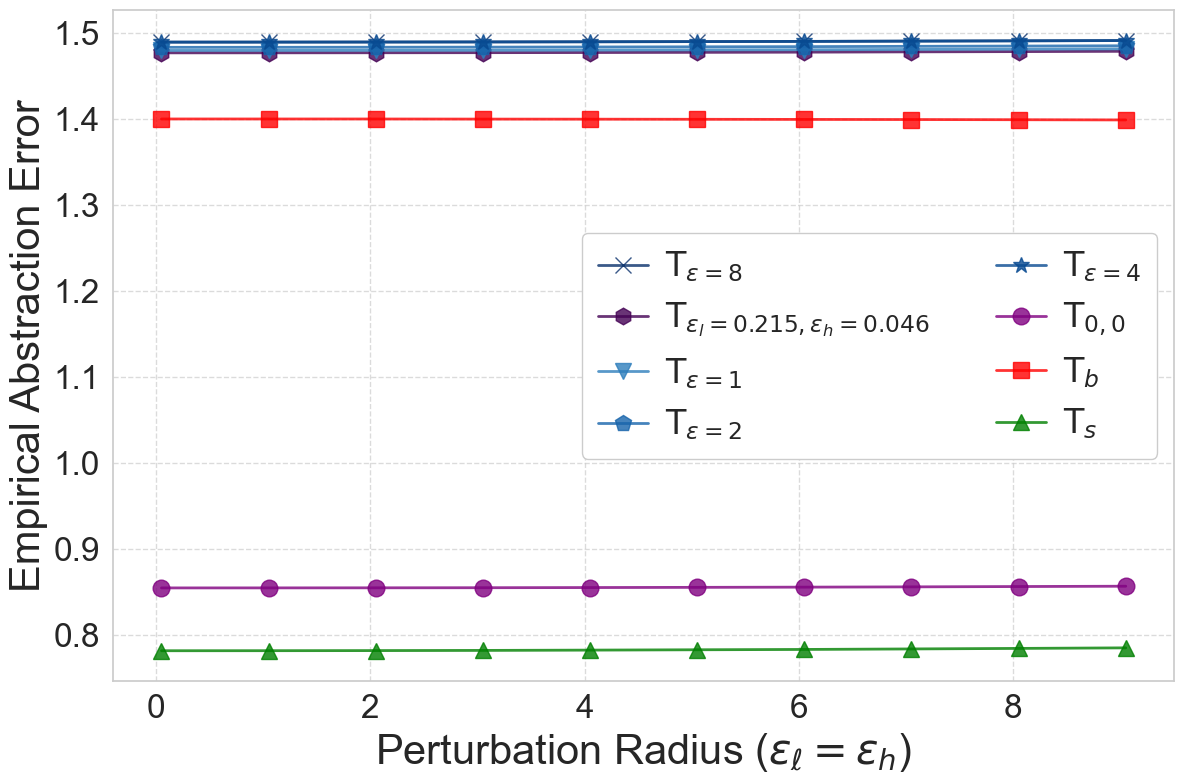

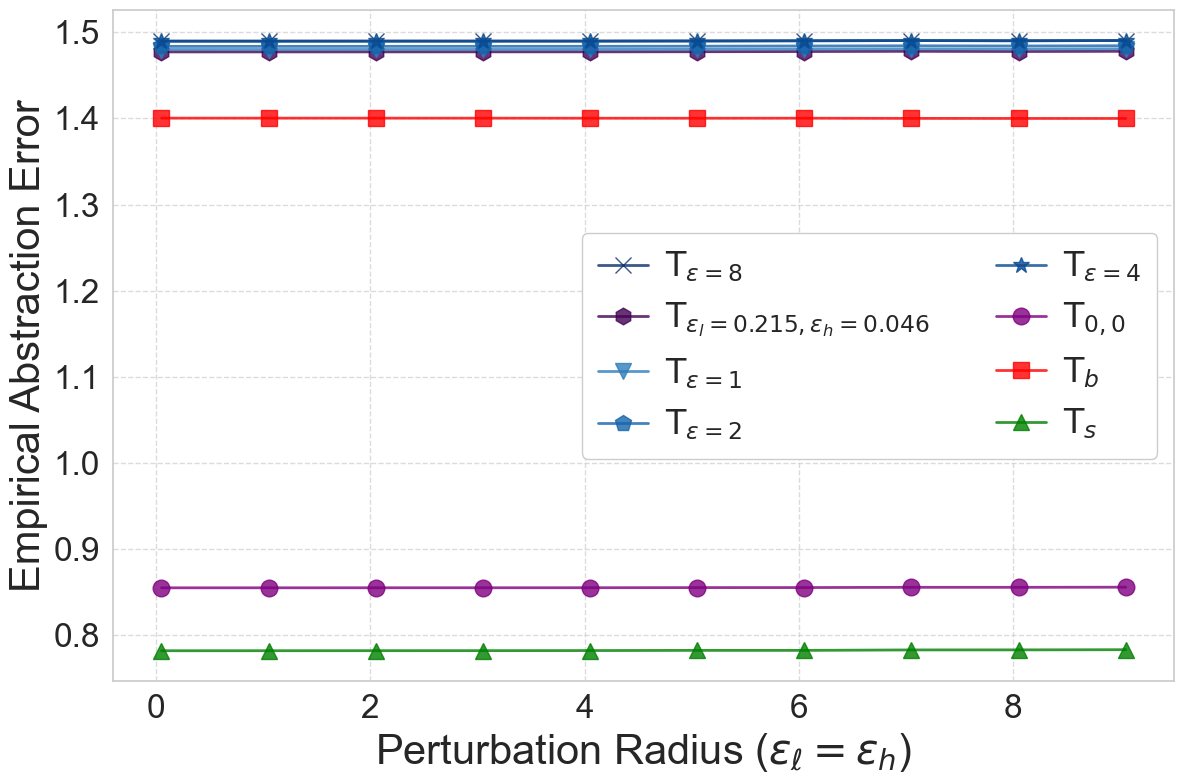

In [56]:
# Example usage with epsilon-delta methods
methods_to_plot = list(T_results_emp.keys())
plot_empirical_abstraction_error(results, methods_to_plot, 'boundary')
plot_empirical_abstraction_error(results, methods_to_plot, 'sample')

### Familly of Pertubations

In [23]:
def generate_perturbation_family(center_matrix, k, r_mu=1.0, r_sigma=1.0, seed=None):
    """
    Generate k perturbation matrices from a base matrix using random shifts.
    
    Args:
        center_matrix: Base matrix to perturb (n, m)
        k: Number of perturbations to generate
        r_mu: Max norm of mean shifts
        r_sigma: Max Frobenius norm of covariance shifts
        seed: Optional random seed
        
    Returns:
        List of perturbation matrices
    """
    if seed is not None:
        np.random.seed(seed)
        
    n, m = center_matrix.shape
    perturbations = []
    
    for _ in range(k):
        # Generate random perturbation matrix
        A = np.random.randn(n, m)
        # Scale to have Frobenius norm = r_sigma
        A = r_sigma * A / np.linalg.norm(A, ord='fro')
        
        # Add mean shift
        delta_mu = np.random.randn(n, m)
        delta_mu = r_mu * delta_mu / np.linalg.norm(delta_mu)
        
        # Combine perturbations
        perturbation = A + delta_mu
        perturbations.append(perturbation)
        
    return perturbations

In [24]:
# Generate perturbation families
pert_family_L = generate_perturbation_family(
    np.zeros_like(hat_dict['L']),
    k=10,  # Number of perturbations
    r_mu=1.0,
    r_sigma=1.0
)

pert_family_H = generate_perturbation_family(
    np.zeros_like(hat_dict['H']),
    k=10,
    r_mu=1.0,
    r_sigma=1.0
)

In [25]:
# Initialize results structure
results = {
    sample_form: {
        'empirical': {method: [] for method in T_results_emp.keys()}
    } for sample_form in sample_forms
}

for pert_L, pert_H in zip(pert_family_L, pert_family_H):
    for sample_form in sample_forms:
        for name, method_data in T_results_emp.items():
            T = method_data['T_matrix']
                
            total = 0
            for iota in test_data.keys():
                base, abst = test_data[iota]
                
                # Apply perturbations
                base_pert = base + pert_L
                abst_pert = abst + pert_H
                
                # Normalize
                base_norm = base_pert / np.linalg.norm(base_pert, 'fro')
                abst_norm = abst_pert / np.linalg.norm(abst_pert, 'fro')
                
                # Apply method and compute distance
                tau_base = base_norm @ T.T
                dist = evut.compute_empirical_distance(tau_base, abst_norm, 'fro')
                total += dist
            
            # Store average error for this iteration
            iter_avg = total / len(test_data.keys())  # Changed from len(Ill) to len(test_data.keys())
            results[sample_form]['empirical'][name].append(iter_avg)

# Print results
print("\n" + "="*100)
print(f"{'Method':<15} {'Empirical Distance (mean ± CI)':<35}")
print("="*100)

for sample_form in sample_forms:
    print(f"\nSample form: {sample_form}")
    print("-"*100)
    
    for method in T_results_emp.keys():
        # Compute statistics for empirical distance
        emp_mean = np.mean(results[sample_form]['empirical'][method])
        emp_std = np.std(results[sample_form]['empirical'][method])
        
        # Print row
        print(f"{method:<15} "
              f"{emp_mean:>8.4f} ± {1.96*emp_std:<8.4f}")

print("="*100)

# Find best methods for empirical distance
for sample_form in sample_forms:
    print(f"\nBest methods for {sample_form} sampling:")
    
    # For empirical distance
    emp_means = {method: np.mean(results[sample_form]['empirical'][method])
                for method in T_results_emp.keys()}
    best_emp = min(emp_means.items(), key=lambda x: x[1])
    
    print(f"Best Empirical: {best_emp[0]} ({best_emp[1]:.4f})")


Method          Empirical Distance (mean ± CI)     

Sample form: boundary
----------------------------------------------------------------------------------------------------
T_8               1.1562 ± 0.0000  
T_0.215-0.046     1.5958 ± 0.0000  
T_1               2.0238 ± 0.0000  
T_2               0.8724 ± 0.0000  
T_4               1.1457 ± 0.0000  
T_0.00            0.7420 ± 0.0000  
T_b               0.7537 ± 0.0000  
T_s               1.3478 ± 0.0000  

Sample form: sample
----------------------------------------------------------------------------------------------------
T_8               1.1562 ± 0.0000  
T_0.215-0.046     1.5958 ± 0.0000  
T_1               2.0238 ± 0.0000  
T_2               0.8724 ± 0.0000  
T_4               1.1457 ± 0.0000  
T_0.00            0.7420 ± 0.0000  
T_b               0.7537 ± 0.0000  
T_s               1.3478 ± 0.0000  

Best methods for boundary sampling:
Best Empirical: T_0.00 (0.7420)

Best methods for sample sampling:
Best Empirical: T_0.0

100%|██████████| 10/10 [00:18<00:00,  1.86s/it]


## F-contamination

In [26]:
def contaminate_empirical_data(data, contamination_fraction, contamination_type, num_segments=10, seed=None):
    """
    Contaminates empirical data to introduce nonlinearities or piecewise changes.
    
    Args:
        data (np.ndarray): Original data matrix (n_samples x n_features)
        contamination_fraction (float): Magnitude of contamination (e.g., between 0.05 and 1.0)
        contamination_type (str): Type of contamination to apply ('multiplicative', 'nonlinear', or 'piecewise')
        num_segments (int): Number of segments for piecewise contamination
        seed (int, optional): Random seed for reproducibility
        
    Returns:
        np.ndarray: The contaminated data matrix
    """
    rng = np.random.default_rng(seed)
    data_cont = data.copy()
    n_samples, n_features = data.shape
    
    if contamination_type == "multiplicative":
        # Apply element-wise multiplicative noise
        noise = rng.uniform(low=1.0 - contamination_fraction, 
                          high=1.0 + contamination_fraction, 
                          size=data.shape)
        data_cont = data * noise
        
    elif contamination_type == "nonlinear":
        # Apply a nonlinear function to the data
        data_cont = data + contamination_fraction * np.sin(data)
        
    elif contamination_type == "piecewise":
        # Contaminate each feature with a piecewise linear function
        def piecewise_contaminate_feature(feature, cont_frac, segments, rng):
            n_points = len(feature)
            if segments < 2:
                return feature
            breakpoints = np.sort(rng.integers(low=1, high=n_points, size=segments - 1))
            breakpoints = np.concatenate(([0], breakpoints, [n_points]))
            contaminated_feature = np.empty_like(feature)
            
            for j in range(len(breakpoints) - 1):
                start = breakpoints[j]
                end = breakpoints[j+1]
                factor = 1.0 + rng.uniform(low=-cont_frac, high=cont_frac)
                contaminated_feature[start:end] = feature[start:end] * factor
            return contaminated_feature
        
        # Apply contamination feature by feature
        for i in range(n_features):
            data_cont[:, i] = piecewise_contaminate_feature(
                data[:, i], contamination_fraction, num_segments, rng
            )
    
    else:
        raise ValueError("Unknown contamination type. Choose among 'multiplicative', 'nonlinear', or 'piecewise'.")
    
    return data_cont

In [30]:
# Define contamination levels to test
contamination_levels = np.linspace(0.0, 10.0, 10)
cont_type = 'nonlinear'  # or 'multiplicative' or 'piecewise'

# Store results for plotting
plot_results = {method: {'means': [], 'stds': []} for method in T_results_emp.keys()}

# Run experiment for each contamination level
for cont_frac in tqdm(contamination_levels):
    abstraction_error = {name: [] for name in T_results_emp.keys()}
    
    for _ in range(5):  # Multiple runs for each contamination level
        for name, res in T_results_emp.items():
            T = res['T_matrix']
            total = 0
            
            for iota in test_data.keys():
                base, abst = test_data[iota]
                
                # Contaminate both base and abstracted data
                base_cont = contaminate_empirical_data(
                    base, 
                    contamination_fraction=cont_frac, 
                    contamination_type=cont_type
                )
                abst_cont = contaminate_empirical_data(
                    abst, 
                    contamination_fraction=cont_frac, 
                    contamination_type=cont_type
                )
                
                # Normalize contaminated data
                base_norm = base_cont / np.linalg.norm(base_cont, 'fro')
                abst_norm = abst_cont / np.linalg.norm(abst_cont, 'fro')
                
                # Apply method and compute distance
                tau_base = base_norm @ T.T
                dist = evut.compute_empirical_distance(tau_base, abst_norm, 'fro')
                total += dist
            
            # Store average error for this iteration
            iter_avg = total / len(test_data.keys())
            abstraction_error[name].append(iter_avg)
    
    # Store results for this contamination level
    for method in T_results_emp.keys():
        mean_e = np.mean(abstraction_error[method])
        std_e = np.std(abstraction_error[method])
        plot_results[method]['means'].append(mean_e)
        plot_results[method]['stds'].append(std_e)

100%|██████████| 10/10 [01:55<00:00, 11.56s/it]


In [33]:
def plot_contamination_results_empirical(plot_results, contamination_levels, cont_type, methods_to_plot=None, method_styles=None):
    """
    Plot the results of empirical contamination analysis for selected methods.
    
    Args:
        plot_results: Dictionary containing means and stds for each method
        contamination_levels: Array of contamination levels tested
        cont_type: Type of contamination applied
        methods_to_plot: List of method names to plot. If None, plots all methods
        method_styles: Optional dictionary of plotting styles for each method
    """
    # If no methods specified, use all methods
    if methods_to_plot is None:
        methods_to_plot = list(plot_results.keys())
    
    # Filter results to only include specified methods
    filtered_results = {method: plot_results[method] 
                      for method in methods_to_plot 
                      if method in plot_results}
    
    # Set default method styles if not provided
    if method_styles is None:
        # Define method styles
        method_styles = {
            'T_0.00': {'color': 'purple', 'label': r'$\mathrm{T}_{0,0}$', 'marker': 'o'},
            'T_b': {'color': 'red', 'label': r'$\mathrm{T}_{b}$', 'marker': 's'},
            'T_s': {'color': 'green', 'label': r'$\mathrm{T}_{s}$', 'marker': '^'},
            'T_ba': {'color': 'orange', 'label': r'$\mathrm{T}_{ba}$', 'marker': 'D'}
        }
        
        # Add styles for trained T matrices using different markers and blues
        blues = plt.cm.Blues(np.linspace(0.6, 1, 5))  # 5 shades of blue
        markers = ['h', 'v', 'p', '*', 'x']  # Different marker shapes
        for i, eps in enumerate(['0.031', '1', '2', '4', '8']):
            method_name = f'T_{eps}'
            method_styles[method_name] = {
                'color': blues[i],
                'label': f'$\\mathrm{{T}}_{{\\varepsilon={eps}}}$',
                'marker': markers[i]
            }
    
    # Set style
    sns.set_theme(style="whitegrid")
    
    # Create figure
    plt.figure(figsize=(12, 8))
    
    # Plot for each selected method
    for method_name in filtered_results.keys():
        style = method_styles.get(method_name, {
            'color': 'black',
            'marker': 'o',
            'label': method_name
        })
        means = filtered_results[method_name]['means']
        stds = filtered_results[method_name]['stds']
        
        # Plot mean line with markers
        plt.plot(contamination_levels, means,
                f"{style['marker']}-",
                color=style['color'],
                label=style['label'],
                markersize=12,
                linewidth=2)
        
        # Add error bands
        plt.fill_between(contamination_levels,
                        np.array(means) - np.array(stds),
                        np.array(means) + np.array(stds),
                        color=style['color'],
                        alpha=0.2)
    
    # Customize plot
    plt.xlabel('Contamination Level', fontsize=30)
    plt.ylabel('Empirical Abstraction Error', fontsize=30)
    plt.title(f'Empirical Abstraction Error vs Contamination Level\n({cont_type} contamination)',
             fontsize=30, pad=20)
    
    plt.xticks(contamination_levels, fontsize=24)
    plt.yticks(fontsize=24)
    
    # Add legend
    plt.legend(prop={'size': 24},
              frameon=True,
              framealpha=1,
              borderpad=0.5,
              handletextpad=0.5,
              handlelength=1.5,
              ncol=2,
              loc='best')
    
    # Add grid and adjust layout
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Print best method for each contamination level
    print("\nBest performing methods at each contamination level:")
    print("="*100)
    for i, cont_frac in enumerate(contamination_levels):
        errors = {method: filtered_results[method]['means'][i] for method in filtered_results.keys()}
        best_method = min(errors.items(), key=lambda x: x[1])
        print(f"Contamination {cont_frac:.2f}: {best_method[0]} (error: {best_method[1]:.4f})")
    print("="*100)


Best performing methods at each contamination level:
Contamination 0.00: T_0.00 (error: 0.7420)
Contamination 1.11: T_0.00 (error: 0.7560)
Contamination 2.22: T_0.00 (error: 0.8113)
Contamination 3.33: T_0.00 (error: 0.8694)
Contamination 4.44: T_0.00 (error: 0.9204)
Contamination 5.56: T_0.00 (error: 0.9634)
Contamination 6.67: T_4 (error: 0.9964)
Contamination 7.78: T_4 (error: 0.9876)
Contamination 8.89: T_4 (error: 0.9807)
Contamination 10.00: T_4 (error: 0.9753)


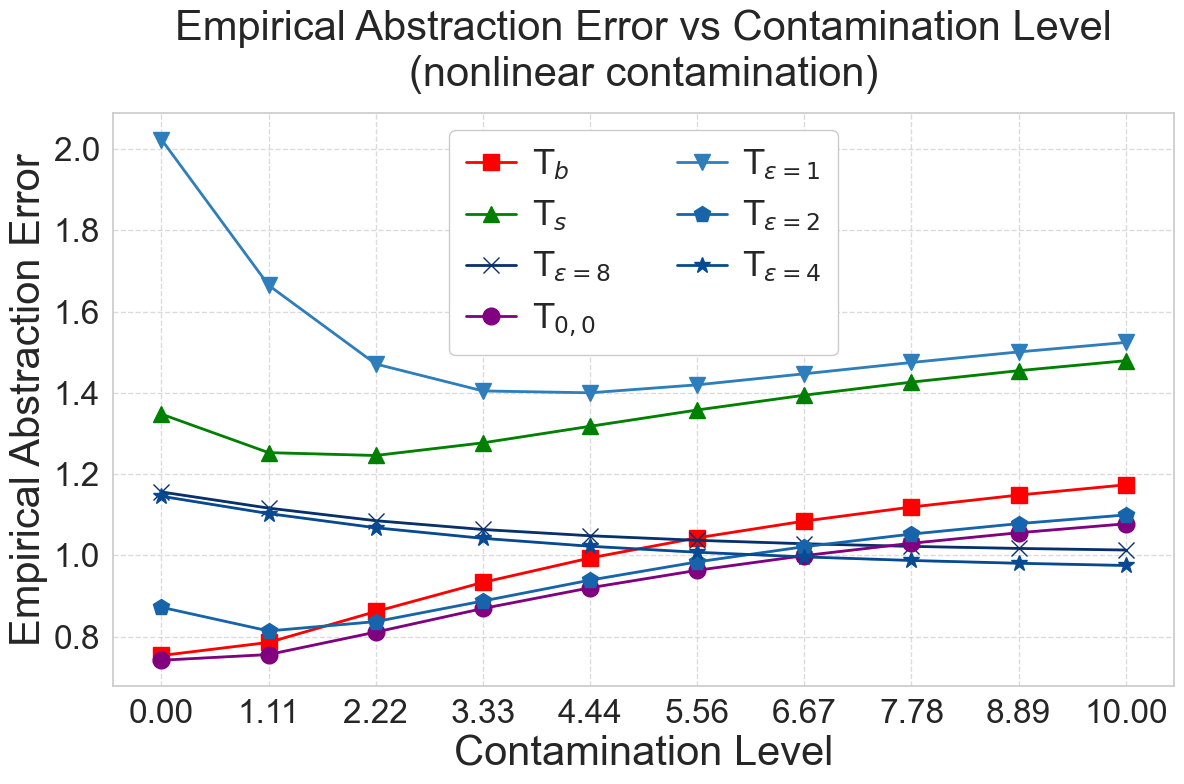

In [34]:
methods_to_plot = ['T_b', 'T_s', 'T_8', 'T_0.00', 'T_0.031', 'T_1', 'T_2', 'T_4', 'T_8']
plot_contamination_results_empirical(plot_results, contamination_levels, cont_type, methods_to_plot)

### ω-contamination

In [35]:
def contaminate_omega_map(original_omega, num_misalignments):
    """
    Randomly corrupt a subset of entries in the ω map to simulate mapping misspecification.
    
    Args:
        original_omega (dict): Original intervention mapping.
            For example: {None: None, iota1: H_i1, iota2: H_i1, iota3: H_i2, ...}
        num_misalignments (int): Desired number of misaligned mappings.
        
    Returns:
        dict: A new ω mapping with up to num_misalignments entries altered.
    """
    # Exclude keys or values that are None if desired.
    omega_keys = [k for k in original_omega.keys() if k is not None]
    omega_vals = [original_omega[k] for k in omega_keys if original_omega[k] is not None]
    
    # Start with a copy of the original mapping.
    contaminated_omega = original_omega.copy()
    
    # Bound the number of misalignments by the number of eligible keys.
    num_to_corrupt = min(num_misalignments, len(omega_keys))
    
    # Randomly select keys to corrupt.
    to_corrupt = random.sample(omega_keys, k=num_to_corrupt)
    
    # Create a random permutation of available targets (ensuring change)
    # Use the set of targets from eligible keys.
    all_targets = list(set(omega_vals))
    
    for key in to_corrupt:
        original_target = original_omega[key]
        # Only corrupt if there's an alternative available.
        available_targets = [t for t in all_targets if t != original_target]
        if available_targets:
            new_target = random.choice(available_targets)
            contaminated_omega[key] = new_target
            
    return contaminated_omega

In [36]:
def plot_omega_contamination_results(omega_plot_results, misalignment_levels, methods_to_plot=None, method_styles=None):
    """
    Plot the results of contamination analysis for selected methods.
    
    Args:
        omega_plot_results: Dictionary containing means and stds for each method
        misalignment_levels: Array of contamination levels tested
        methods_to_plot: List of method names to plot. If None, plots all methods
        method_styles: Optional dictionary of plotting styles for each method
    """
    # If no methods specified, use all methods
    if methods_to_plot is None:
        methods_to_plot = list(omega_plot_results.keys())
    
    # Filter results to only include specified methods
    filtered_results = {method: omega_plot_results[method] 
                      for method in methods_to_plot 
                      if method in omega_plot_results}
    
    # Set default method styles if not provided
    if method_styles is None:
        colors = plt.cm.tab10(np.linspace(0, 1, len(filtered_results)))
        method_styles = {
            method: {
                'color': colors[i],
                'marker': 'o',
                'label': method
            }
            for i, method in enumerate(filtered_results.keys())
        }
    
    # Set style
    sns.set_theme(style="whitegrid")
    
    # Create figure
    plt.figure(figsize=(12, 8))
    
    # Plot for each selected method
    for method_name in filtered_results.keys():
        style = method_styles.get(method_name, {
            'color': 'black',
            'marker': 'o',
            'label': method_name
        })
        means = filtered_results[method_name]['means']
        stds = filtered_results[method_name]['stds']
        
        # Plot mean line with markers
        plt.plot(misalignment_levels, means,
                f"{style['marker']}-",
                color=style['color'],
                label=style['label'],
                markersize=8,
                linewidth=2)
        
        # Add error bands
        plt.fill_between(misalignment_levels,
                        np.array(means) - np.array(stds),
                        np.array(means) + np.array(stds),
                        color=style['color'],
                        alpha=0.2)
    
    # Customize plot
    plt.xlabel('Number of Misalignments', fontsize=16)
    plt.ylabel('Abstraction Error', fontsize=16)
    plt.title(f'Abstraction Error vs Number of Misalignments',
             fontsize=16, pad=20)
    
    plt.xticks(misalignment_levels, fontsize=14)
    plt.yticks(fontsize=14)
    
    # Add legend
    plt.legend(prop={'size': 12},
              frameon=True,
              framealpha=1,
              borderpad=1,
              handletextpad=1,
              handlelength=2,
              bbox_to_anchor=(1.05, 1),
              loc='upper left')
    
    # Add grid and adjust layout
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Print best method for each contamination level
    print("\nBest performing methods at each misalignment level:")
    for i, num_mis in enumerate(misalignment_levels):
        errors = {method: filtered_results[method]['means'][i] for method in filtered_results.keys()}
        best_method = min(errors.items(), key=lambda x: x[1])
        print(f"Misalignments {num_mis}: {best_method[0]} (error: {best_method[1]:.4f})")

100%|██████████| 15/15 [00:38<00:00,  2.58s/it]



Best performing methods at each misalignment level:
Misalignments 0: T_0.00 (error: 0.7420)
Misalignments 1: T_0.00 (error: 0.7421)
Misalignments 2: T_0.00 (error: 0.7416)
Misalignments 3: T_0.00 (error: 0.7413)
Misalignments 4: T_0.00 (error: 0.7410)
Misalignments 5: T_0.00 (error: 0.7419)
Misalignments 6: T_0.00 (error: 0.7421)
Misalignments 7: T_0.00 (error: 0.7405)
Misalignments 8: T_0.00 (error: 0.7404)
Misalignments 9: T_0.00 (error: 0.7402)
Misalignments 10: T_0.00 (error: 0.7408)
Misalignments 11: T_0.00 (error: 0.7405)
Misalignments 12: T_0.00 (error: 0.7412)
Misalignments 13: T_0.00 (error: 0.7419)
Misalignments 14: T_0.00 (error: 0.7403)


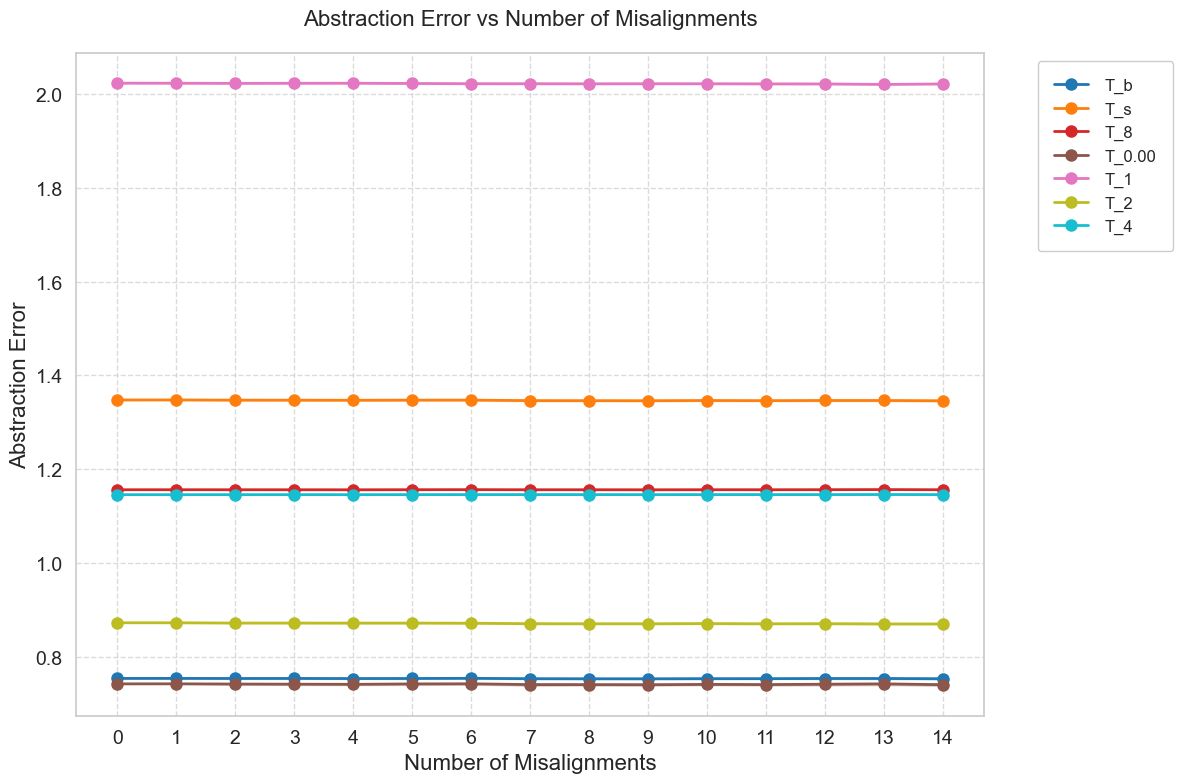

In [38]:
# Define misalignment levels to test
misalignment_levels = range(0, 15)  # Test 0 to 15 misalignments

# Store results for plotting
omega_plot_results = {method: {'means': [], 'stds': []} for method in T_results_emp.keys()}

# Run experiment for each misalignment level
for num_mis in tqdm(misalignment_levels):
    abstraction_error = {name: [] for name in T_results_emp.keys()}
    
    for _ in range(10):  # Multiple runs for each misalignment level
        # Contaminate the omega map
        omega_cont = contaminate_omega_map(omega, num_mis)
        
        # Generate new data pairs using the contaminated omega map
        contaminated_data = evut.generate_empirical_data(
            LLmodels, 
            HLmodels, 
            omega_cont,  # Use contaminated omega map
            U_ll_hat, 
            U_hl_hat
        )
        
        for name, res in T_results_emp.items():
            T = res['T_matrix']
            total = 0
            
            for iota in contaminated_data.keys():
                base, abst = contaminated_data[iota]
                
                # Normalize data
                base_norm = base / np.linalg.norm(base, 'fro')
                abst_norm = abst / np.linalg.norm(abst, 'fro')
                
                # Apply method and compute distance
                tau_base = base_norm @ T.T
                dist = evut.compute_empirical_distance(tau_base, abst_norm, 'fro')
                total += dist
            
            # Store average error for this iteration
            iter_avg = total / len(contaminated_data.keys())
            abstraction_error[name].append(iter_avg)
    
    # Store results for this misalignment level
    for method in T_results_emp.keys():
        mean_e = np.mean(abstraction_error[method])
        std_e = np.std(abstraction_error[method])
        omega_plot_results[method]['means'].append(mean_e)
        omega_plot_results[method]['stds'].append(std_e)

# Plot results
methods_to_plot = ['T_b', 'T_s', 'T_8', 'T_0.00', 'T_0.031', 'T_1', 'T_2', 'T_4', 'T_8']
plot_omega_contamination_results(
    omega_plot_results, 
    misalignment_levels, 
    methods_to_plot=methods_to_plot
)